In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:
train_perc = 0.5
M = 100
stump_steps = 100

In [3]:
X = np.genfromtxt('banknote_auth_data.csv', delimiter=',')
t = np.genfromtxt('banknote_auth_labels.csv', delimiter=',') * 2 - 1
indx = np.random.permutation(X.shape[0])
X = X[indx]
t = t[indx]
val_indx = (int)(X.shape[0] * train_perc)
X_train = X[:val_indx]
t_train = t[:val_indx]
X_val = X[val_indx:]
t_val = t[val_indx:]

In [60]:
class DecStump:
    def __init__(self):
        self.theta = 0
        self.dim = 0
        self.sgn = 1
        
    def fit(self, X, t, weights, test_func, features_to_use=0):
        best_err = 0
        best_param = None
        test_func = self.test_exp if test_func == 'exp' else self.test_logit
        
        if features_to_use > 0:
            dimensions = np.random.choice(X.shape[1], features_to_use)
        else:
            dimensions = range(X.shape[1])
        
        for sgn in [-1, 1]:
            self.sgn = sgn
            for d in dimensions:
                self.dim = d
                if X[:,d].min() < X[:,d].max():
                    steps = np.arange(X[:,d].min(), X[:,d].max(), (X[:,d].max() - X[:,d].min()) / stump_steps)
                else:
                    steps = [X[:,d].min()]
                for s in steps:
                    self.theta = s
                    err = test_func(X, t, weights)
                    if best_param is None or best_err > err:
                        best_param = self.dim, self.theta, self.sgn
                        best_err = err

        self.dim, self.theta, self.sgn = best_param
        return best_err
        
    def predict(self, X):
        return (X[:, self.dim] * self.sgn >= self.theta * self.sgn).astype(int) * 2 - 1           
    
    def test_exp(self, X, t, weights):
        if weights is None:
            weights = np.full(t.shape, 1 / t.shape[0])
        y = self.predict(X)
        return np.sum((y != t) * weights) / np.sum(weights)
    
    def test_logit(self, X, z, weights):
        if weights is None:
            weights = np.full(t.shape, 1 / t.shape[0])
        y = self.predict(X)
        return np.sum(weights * ((z - y) ** 2))

In [63]:
class DecTree:
    def __init__(self):
        self.left = None
        self.right = None
        self.stump = DecStump()

    def fit(self, X, t, weights, test_func, features_to_use, layers=4):
        self.stump.fit(X, t, weights, test_func, features_to_use)
        
        if layers > 0:
            y = self.stump.predict(X)
            if X[y >= 0].shape[0] > 1 and X[y >= 0].max():
                self.left = DecTree()
                self.left.fit(X[y >= 0], t[y >= 0], weights, test_func, features_to_use, layers - 1)
            
            if X[y < 0].shape[0] > 1 and X[y < 0].max():
                self.right = DecTree()
                self.right.fit(X[y < 0], t[y < 0], weights, test_func, features_to_use, layers - 1)
    
    def predict(self, X):
        y = self.stump.predict(X)
        
        y_res = np.zeros_like(y)
        if self.left is not None:
            y_res[y >= 0] = self.left.predict(X[y >= 0])
        else:
            y_res[y >= 0] = y[y >= 0]
            
        if self.right is not None:
            y_res[y < 0] = self.right.predict(X[y < 0])
        else:
            y_res[y < 0] = y[y < 0]
                    
        return y_res
    

In [42]:
class AdaBoost:
    def __init__(self):
        self.classifiers = []
        self.alpha = []
        
    def fit(self, X_train, t_train, X_val, t_val, classifier_class):
        self.classifiers = []
        self.alpha = []        
        weights = np.full(t_train.shape, 1 / t_train.shape[0])
        
        errors = []
        
        for m in range(M):
            self.classifiers.append(classifier_class())
            
            err = self.classifiers[-1].fit(X_train, t_train, weights, 'exp')
            self.alpha.append(np.log((1 - err) / err))
            
            y = self.classifiers[-1].predict(X_train)
            weights = weights * np.exp(self.alpha[-1] * (y != t_train))
            
            errors.append(self.test(X_val, t_val))
            
        return errors
            
    def predict(self, X):
        y_res = np.zeros([X.shape[0]])
        for m in range(len(self.classifiers)):
            y_res += self.alpha[m] * self.classifiers[m].predict(X)
        return (y_res > 0).astype(int) * 2 - 1
            
    def test(self, X, t):
        y = self.predict(X)
        return np.sum(y != t) / X.shape[0]

In [43]:
class LogitBoost:
    def __init__(self):
        self.classifiers = []
        
    def fit(self, X_train, t_train, X_val, t_val, classifier_class):
        self.classifiers = []
        pi = np.full(t_train.shape, 0.5)
        y = np.full(t_train.shape, 0.0)
        
        errors = []
        
        for m in range(M):
            weights = pi * (1 - pi)
            z = ((t_train + 1) / 2 - pi) / weights
            
            #z_nans = np.isnan(z) | np.isinf(z)
            #z[z_nans] = t_train[z_nans]
            
            self.classifiers.append(classifier_class())
            self.classifiers[-1].fit(X_train, z, weights, 'logit')
            
            y += 0.5 * self.classifiers[-1].predict(X_train)
            pi = 1 / (1 + np.exp(-2 * y))
            
            errors.append(self.test(X_train, t_train))
            
        return errors
    
    def predict(self, X):
        y_res = np.zeros([X.shape[0]])
        for m in range(len(self.classifiers)):
            y_res += self.classifiers[m].predict(X)
        return (y_res > 0).astype(int) * 2 - 1          
            
    def test(self, X, t):
        y = self.predict(X)
        return np.sum(y != t) / X.shape[0]

In [66]:
class Bagging:
    def __init__(self):
        self.classifiers = []
        
    def fit(self, X_train, t_train, X_val, t_val, classifier_class):
        errors = []
        
        for i in range(M):
            indx = np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.3))
            X_set = X_train[indx]
            t_set = t_train[indx]
            
            self.classifiers.append(classifier_class())
            err = self.classifiers[-1].fit(X_set, t_set, None, 'exp', 2)
            
            errors.append(self.test(X_train, t_train))
            
        return errors
            
    def predict(self, X):
        y_res = np.zeros([X.shape[0]])
        for m in range(len(self.classifiers)):
            y_res += self.classifiers[m].predict(X)
        return (y_res > 0).astype(int) * 2 - 1 
    
    def test(self, X, t):
        y = self.predict(X)
        return np.sum(y != t) / X.shape[0]

In [69]:
ada_boost = AdaBoost()
ada_errors = ada_boost.fit(X_train, t_train, X_val, t_val, DecStump)

In [70]:
logit_boost = LogitBoost()
logit_errors = logit_boost.fit(X_train, t_train, X_val, t_val, DecStump)

In [71]:
bagging = Bagging()
bagging_errors = bagging.fit(X_train, t_train, X_val, t_val, DecStump)

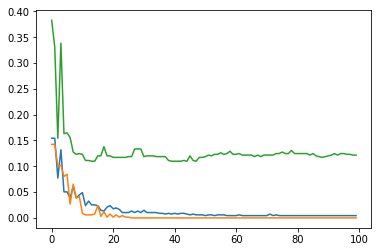

In [72]:
fig = plt.figure()
ax = plt.axes()

ax.plot(np.arange(len(ada_errors)), ada_errors)
ax.plot(np.arange(len(logit_errors)), logit_errors)
ax.plot(np.arange(len(bagging_errors)), bagging_errors )

In [13]:
np.min(ada_errors), np.min(logit_errors)

(0.1543026706231454, 0.0)

In [67]:
bagging = Bagging()
bagging_errors = bagging.fit(X_train, t_train, X_val, t_val, DecTree)

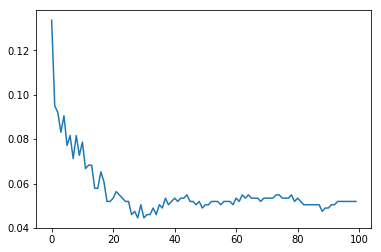

In [68]:
fig = plt.figure()
ax = plt.axes()

#ax.plot(np.arange(len(ada_errors)), ada_errors)
#ax.plot(np.arange(len(logit_errors)), logit_errors)
ax.plot(np.arange(len(bagging_errors)), bagging_errors)